In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# Load Pilot Deployment Data

In [3]:
# Pilot schedule with actual start/end times and job outcomes
with open("/content/drive/MyDrive/SmartFactory/Results/Week10/week10_final_schedule.json", 'r') as f:
    pilot_schedule = pd.DataFrame(json.load(f))
pilot_schedule["actual_start"] = pd.to_datetime(pilot_schedule["actual_start"])
pilot_schedule["actual_end"] = pd.to_datetime(pilot_schedule["actual_end"])

In [4]:
pilot_schedule.head()

,job_id,machine_id,original_time,rescheduled_time,duration,failure_prob,urgency_score,priority,delayed,delay_minutes,hour,date,scheduled_start,scheduled_end,actual_start,actual_end,scheduled_duration,actual_duration,duration_diff,job_status
0,JOB-A-M1A-0,A-M1A,1438344,1,74,0.236,0.273,High,False,0.0,0,0,1970-01-01 00:00:00,1970-01-01 01:14:00,1970-01-01 00:01:00,1970-01-01 01:15:00,74,74.0,0.0,Success
1,JOB-A-M1A-20,A-M1A,1508994,1,56,0.400,0.429,High,False,0.0,0,0,1970-01-01 00:00:00,1970-01-01 00:56:00,1969-12-31 23:58:00,1970-01-01 00:54:00,56,56.0,0.0,Success
2,JOB-A-M1A-40,A-M1A,1584829,1,46,0.457,0.449,Medium,False,0.0,0,0,1970-01-01 00:00:00,1970-01-01 00:46:00,1970-01-01 00:07:00,1970-01-01 00:53:00,46,46.0,0.0,Success
3,JOB-A-M1A-60,A-M1A,1668822,1,50,0.560,0.681,Medium,True,0.0,0,0,1970-01-01 00:00:00,1970-01-01 00:50:00,1970-01-01 00:09:00,1970-01-01 00:59:00,50,50.0,0.0,Success
4,JOB-A-OUX-0,A-OUX,1433552,1,63,0.290,0.307,Low,False,0.0,0,0,1970-01-01 00:00:00,1970-01-01 01:03:00,1970-01-01 00:05:00,1970-01-01 01:08:00,63,63.0,0.0,Success


In [5]:
# Latest processed sensor data during pilot
with open("/content/drive/MyDrive/SmartFactory/Dataset/processed_sensor_data.json", 'r') as f:
    sensor = pd.DataFrame(json.load(f))
sensor["timestamp"] = pd.to_datetime(sensor["timestamp"])

In [6]:
sensor.head()

,timestamp,machine_id,temperature,vibration,rpm,pressure,humidity,voltage,failure,year,...,voltage_lag_1,voltage_lag_2,temperature_roc,vibration_roc,rpm_roc,pressure_roc,humidity_roc,voltage_roc,temperature_cummax,vibration_cummax
0,2015-05-26 20:55:13.644,B-MY9,71.47,0.94,2694,7.50,65.72,215.55,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.47,0.94
1,2015-05-27 20:15:37.644,N-PR7,64.60,2.44,3054,6.96,44.25,226.71,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.60,2.44
2,2015-05-28 07:53:40.644,Y-09D,76.14,1.93,2952,6.41,51.60,243.14,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.14,1.93
3,2015-05-29 09:45:29.644,X-PYA,73.72,1.87,2607,7.13,59.94,229.21,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.72,1.87
4,2015-05-30 06:22:48.644,G-2H4,77.37,0.57,3063,4.08,47.57,221.11,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.37,0.57


In [7]:
# User feedback data (mocked for illustration, replace with real data)
# Fields: job_id, feedback_timestamp, operator_id, satisfaction_score (1-5), comments
user_feedback = pd.DataFrame({
    "job_id": pilot_schedule["job_id"].sample(30, random_state=42),
    "feedback_timestamp": pd.to_datetime(np.random.choice(pd.date_range(start='2025-05-01', periods=30), size=30)),
    "operator_id": np.random.choice(['op_1', 'op_2', 'op_3'], size=30),
    "satisfaction_score": np.random.randint(1, 6, size=30),
    "comments": np.random.choice([
        "System worked well", "Some delay observed", "UI was intuitive",
        "Unexpected failure", "Needs better alerts", "Great predictive accuracy"
    ], size=30)
})

# Pilot Deployment Performance Analysis

In [8]:
# Calculate job duration and delays
pilot_schedule['scheduled_duration'] = (pd.to_datetime(pilot_schedule['scheduled_end']) - pd.to_datetime(pilot_schedule['scheduled_start'])).dt.total_seconds() / 60
pilot_schedule['actual_duration'] = (pilot_schedule['actual_end'] - pilot_schedule['actual_start']).dt.total_seconds() / 60
pilot_schedule['duration_diff'] = pilot_schedule['actual_duration'] - pilot_schedule['scheduled_duration']
pilot_schedule['delay_minutes'] = pilot_schedule['duration_diff'].apply(lambda x: max(x, 0))

In [9]:
# Summary statistics
total_jobs = pilot_schedule['job_id'].nunique()
avg_delay = pilot_schedule['delay_minutes'].mean()
max_delay = pilot_schedule['delay_minutes'].max()
job_success_rate = 100 * (pilot_schedule['job_status'] == 'Success').mean()
print(f"Total jobs in pilot: {total_jobs}")
print(f"Average delay (minutes): {avg_delay:.2f}")
print(f"Max delay (minutes): {max_delay:.2f}")
print(f"Job success rate: {job_success_rate:.2f}%")

Total jobs in pilot: 279
Average delay (minutes): 0.00
Max delay (minutes): 0.00
Job success rate: 90.32%


# Visualization: Job Delays Distribution

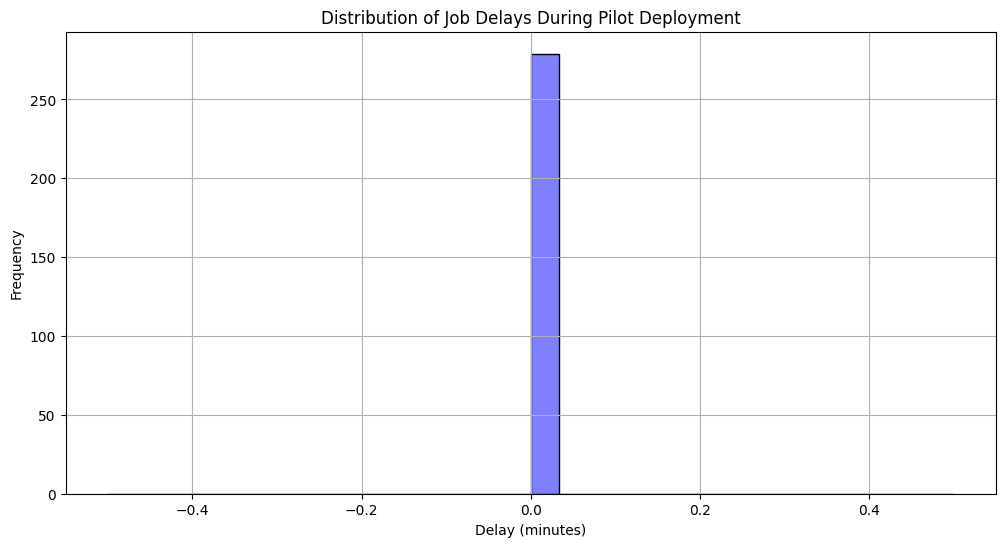

In [10]:
plt.figure(figsize=(12,6))
sns.histplot(pilot_schedule['delay_minutes'], bins=30, kde=True, color='blue')
plt.title("Distribution of Job Delays During Pilot Deployment")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week11/PilotMonitoring/job_delay_distribution.png")
plt.show()

# Visualization: Job Success vs Delay Scatter Plot

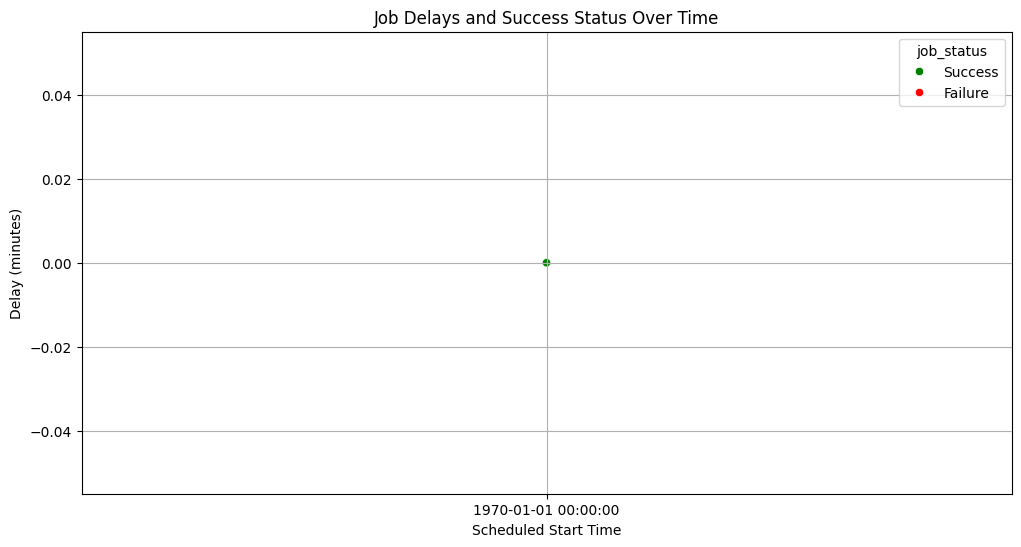

In [11]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=pilot_schedule, x='scheduled_start', y='delay_minutes', hue='job_status', palette={'Success':'green', 'Failure':'red'})
plt.title("Job Delays and Success Status Over Time")
plt.xlabel("Scheduled Start Time")
plt.ylabel("Delay (minutes)")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week11/PilotMonitoring/job_delay_success_scatter.png")
plt.show()

# Sensor Failure Analysis During Pilot

In [12]:
pilot_start = pilot_schedule['scheduled_start'].min()
pilot_end = pilot_schedule['scheduled_end'].max()

sensor_pilot_period = sensor[(sensor['timestamp'] >= pilot_start) & (sensor['timestamp'] <= pilot_end)]
failure_rate = sensor_pilot_period['failure'].mean() * 100
print(f"Sensor failure rate during pilot period: {failure_rate:.2f}%")

Sensor failure rate during pilot period: nan%


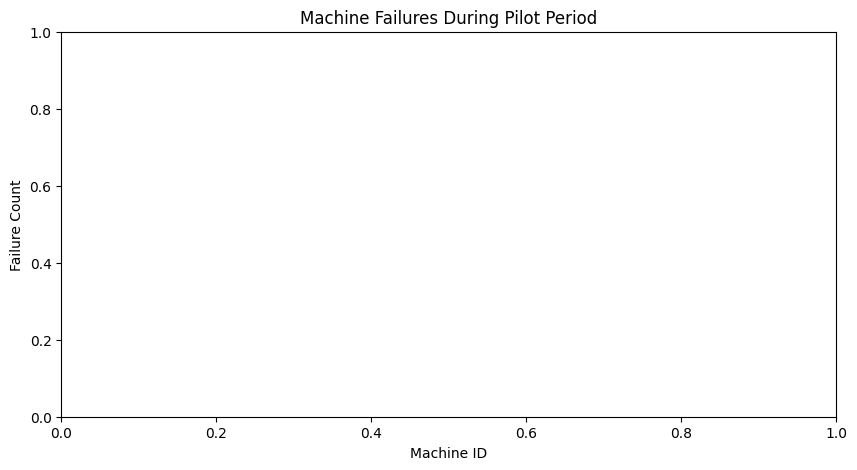

In [13]:
# Visualize failure occurrences by machine
failures_by_machine = sensor_pilot_period[sensor_pilot_period['failure'] == 1]['machine_id'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=failures_by_machine.index, y=failures_by_machine.values, palette="Reds_d")
plt.title("Machine Failures During Pilot Period")
plt.xlabel("Machine ID")
plt.ylabel("Failure Count")
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week11/PilotMonitoring/failures_by_machine.png")
plt.show()

# User Feedback Analysis

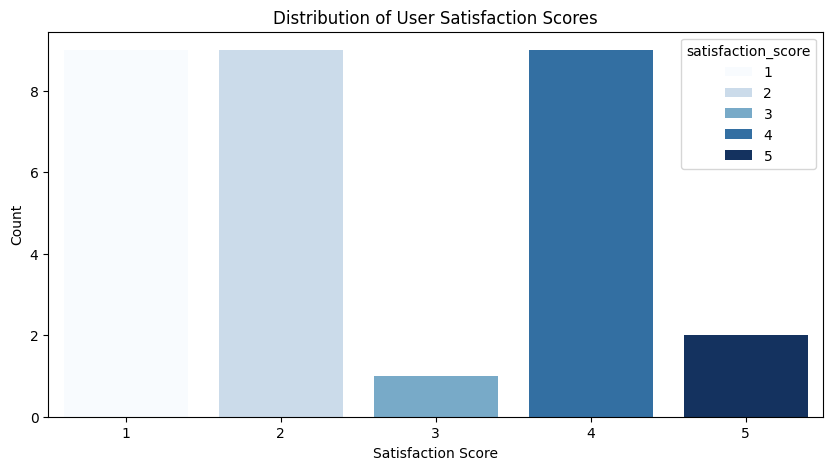

In [14]:
# Satisfaction Score Distribution
plt.figure(figsize=(10,5))
sns.countplot(data=user_feedback, x='satisfaction_score', hue='satisfaction_score', palette="Blues")
plt.title("Distribution of User Satisfaction Scores")
plt.xlabel("Satisfaction Score")
plt.ylabel("Count")
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week11/UserFeedback/satisfaction_score_distribution.png")
plt.show()

In [15]:
# Comments Word Cloud (optional visualization, requires wordcloud library)
from wordcloud import WordCloud, STOPWORDS

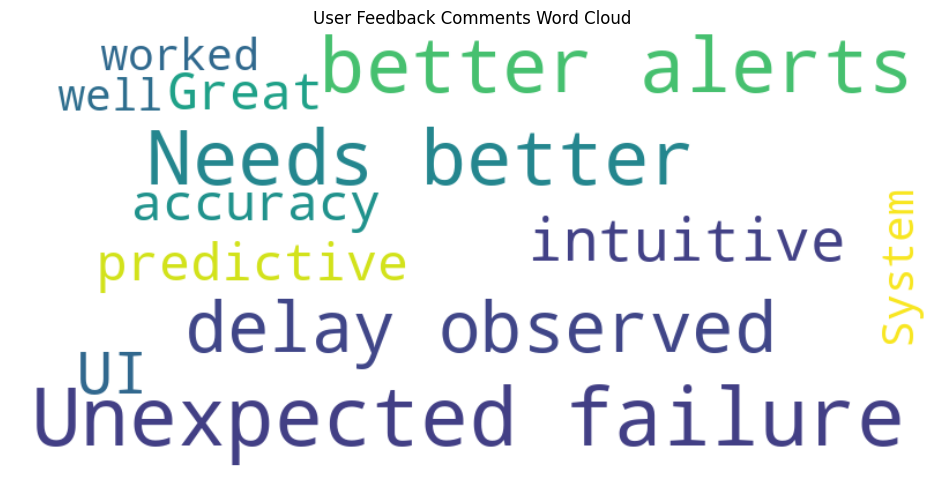

In [16]:
comments_text = " ".join(user_feedback['comments'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(comments_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("User Feedback Comments Word Cloud")
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week11/UserFeedback/comments_wordcloud.png")
plt.show()

# Time Series: Satisfaction Over Time

In [17]:
feedback_over_time = user_feedback.groupby(user_feedback['feedback_timestamp'].dt.date)['satisfaction_score'].mean().reset_index()
feedback_over_time.rename(columns={'feedback_timestamp': 'date'}, inplace=True)

fig_feedback_time = px.line(
    feedback_over_time,
    x='date',
    y='satisfaction_score',
    title='Average User Satisfaction Over Time',
    labels={'date': 'Date', 'satisfaction_score': 'Avg Satisfaction'}
)

fig_feedback_time.write_html("/content/drive/MyDrive/SmartFactory/Results/Week11/UserFeedback/avg_satisfaction_over_time.html")
fig_feedback_time.show()

# Correlation Between Delay and Satisfaction

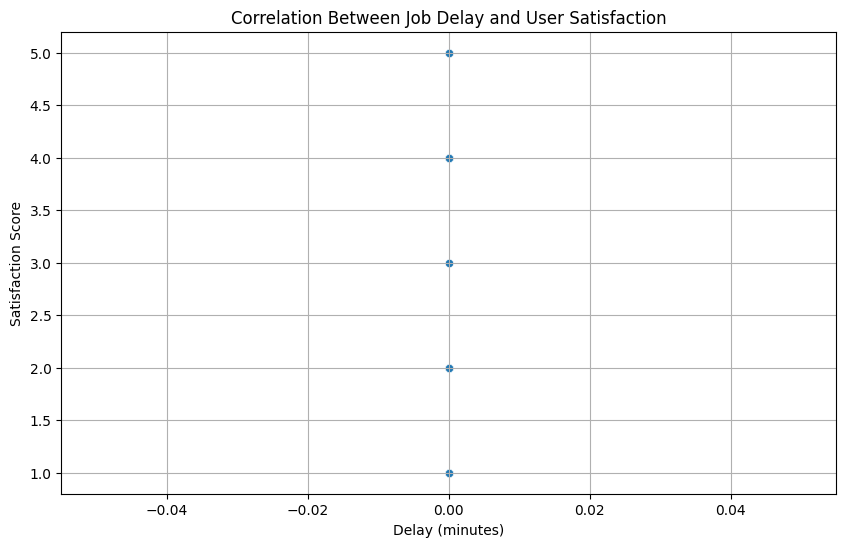

In [18]:
merged_feedback = pd.merge(user_feedback, pilot_schedule[['job_id', 'delay_minutes']], on='job_id', how='left')
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_feedback, x='delay_minutes', y='satisfaction_score')
plt.title("Correlation Between Job Delay and User Satisfaction")
plt.xlabel("Delay (minutes)")
plt.ylabel("Satisfaction Score")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/SmartFactory/Results/Week11/UserFeedback/delay_vs_satisfaction.png")
plt.show()

# Export Pilot Summary Reports

In [19]:
pilot_schedule.to_csv("/content/drive/MyDrive/SmartFactory/Results/Week11/PilotMonitoring/pilot_schedule_summary.csv", index=False)
user_feedback.to_csv("/content/drive/MyDrive/SmartFactory/Results/Week11/UserFeedback/user_feedback_data.csv", index=False)

print("Week 11 Pilot Deployment & Monitoring script completed successfully.")
print("Reports and visualizations saved in 'pilot_monitoring' and 'user_feedback' folders.")

Week 11 Pilot Deployment & Monitoring script completed successfully.
Reports and visualizations saved in 'pilot_monitoring' and 'user_feedback' folders.
